# 01. 미국 ETF (QQQ) 주가 예측하기
>- 링크: https://finance.yahoo.com/quote/QQQ/history?p=QQQ

>- 개별 종목은 외부 변수의 영향을 너무 많이 받을 것 같으니, 지수추종 ETF를 다뤄봅시다.
>- QQQ는 NASDAQ(나스닥)을 추종하는 ETF입니다. 정확히는 상위 100위권까지의 기업이 포함된 나스닥100을 추종합니다.
>- 시가총액을 기준으로 산출되는 지수로서, 주로 기술기업주로 구성돼 있습니다.
>- 자연스럽게 QQQ의 포트폴리오 구성도 기술주 위주로 되어 있죠.

## (1) 필요한 함수 가져오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

print('Done!')

Done!


## (2) 시계열 데이터 준비하기

In [2]:
# Time Series 시계열 데이터 준비

data_path = os.getenv('HOME') + '/aiffel/exploration/E_03/QQQ.csv'
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
ts = df['Close']

print(ts.head())
print(ts.shape) # 총 252개

Date
2021-05-03    336.190002
2021-05-04    330.140015
2021-05-05    329.029999
2021-05-06    331.510010
2021-05-07    334.200012
Name: Close, dtype: float64
(252,)


▶︎ 음, 날짜별 종가 데이터가 잘 불러와졌습니다.

### (3) 결측치 처리하기 ###

In [3]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series[]로 출력

Series([], Name: Close, dtype: float64)

▶︎ 결측치는 따로 없네요.

### (4) stationarity 검증

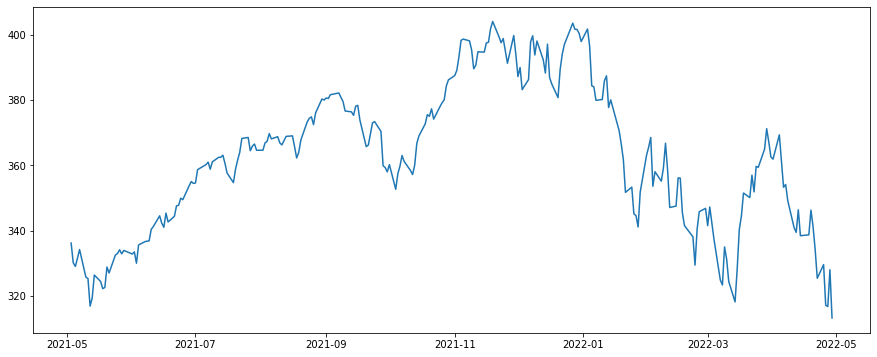

In [4]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 6
plt.plot(ts)

▶︎ 딱 봐도 별로 stationary 하지 않아 보입니다.

### (5) 로그 변환 ###

In [5]:
ts_log = np.log(ts)
print('Done!')

Done!


▶︎ 그래프를 보니 편차가 크네요. 로그 변환을 해 줍시다.

이제 좀 안정화가 되었을까요?

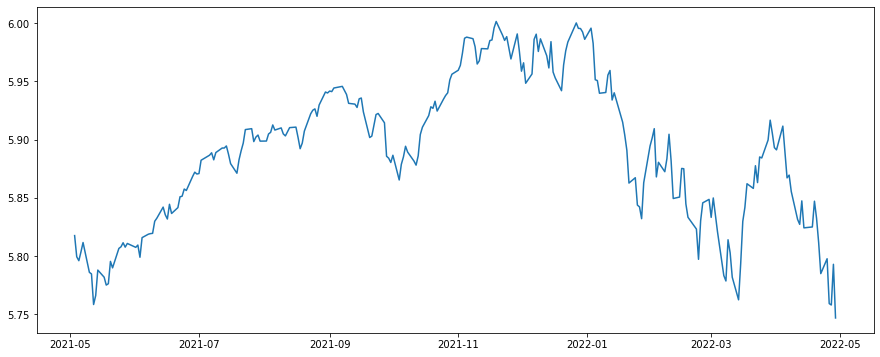

In [6]:
plt.plot(ts_log)

▶︎ y축을 보니 값이 잘 조정되었습니다. 편차가 많이 줄었겠군요.

하지만 여전히 불안정한 것처럼 보입니다. 다른 방법을 써보도록 하겠습니다.

### (6) 안정성 분석을 위한 사전 작업 ###

In [7]:
## 구간 통계치 (rolling statistics) 시각화 함수

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
## ADF Test 함수
# 주어진 시계열이 불안정하다 (귀무가설)

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지의 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller에서 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    
print('Done!')

Done!


▶︎ 데이터 처리 및 시각화를 위한 함수를 정의해줍니다. 데이터가 불안정하니 ADF test를 위한 함수를 생성합니다.

## (7) 시계열 안정성 분석 ##

### (7-1) 정성적 그래프 분석 ###

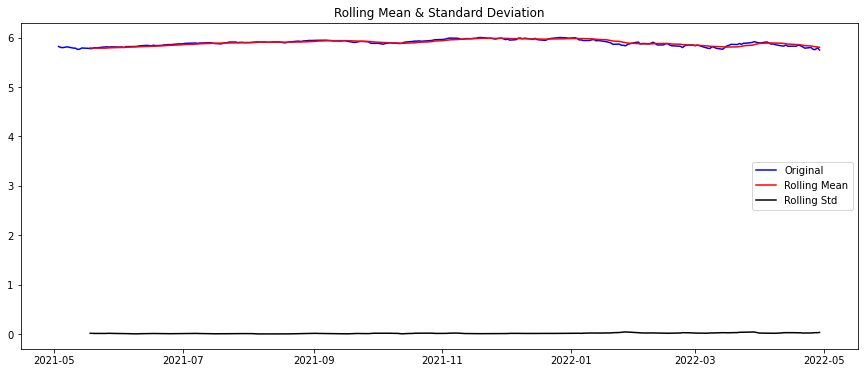

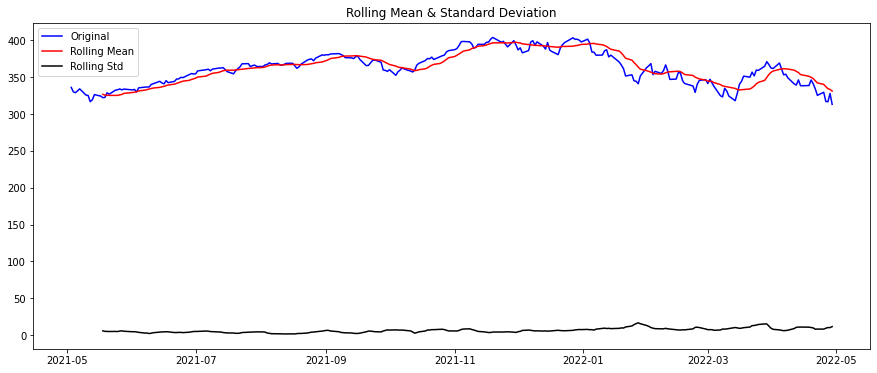

In [8]:
# MA 분석
plot_rolling_statistics(ts_log, window=12)
plot_rolling_statistics(ts, window=12)

▶︎ 역시 로그를 취해주니 안정성이 개선되긴 했습니다.

하지만 이걸로는 진짜로 안정적인지 아닌지 잘 모르겠네요.

일단 계속 진행해 보겠습니다.

### (7-2) 정량적 ADF test

In [9]:
# 정량적 ADF test

augmented_dickey_fuller_test(ts_log)
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.276861
p-value                          0.639691
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -1.306045
p-value                          0.626402
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


▶︎ 음, ts와 ts_log 둘 다 p값이 0.5보다 큽니다.

이러면 아까 "이 시계열이 불안정하다" 라고 잡은 귀무가설을 기각할 수가 없게 됩니다.

#### 이 가설을 채택할 수는 없지만, 적어도 "ts와 ts_log 두 데이터 모두 안정적인 시계열은 아니다"는 가설을 채택할 수는 있겠죠?

그럼 이제 안정화를 위해 다른 방법을 더 시도해보겠습니다.

### (7-3) 시계열 분해

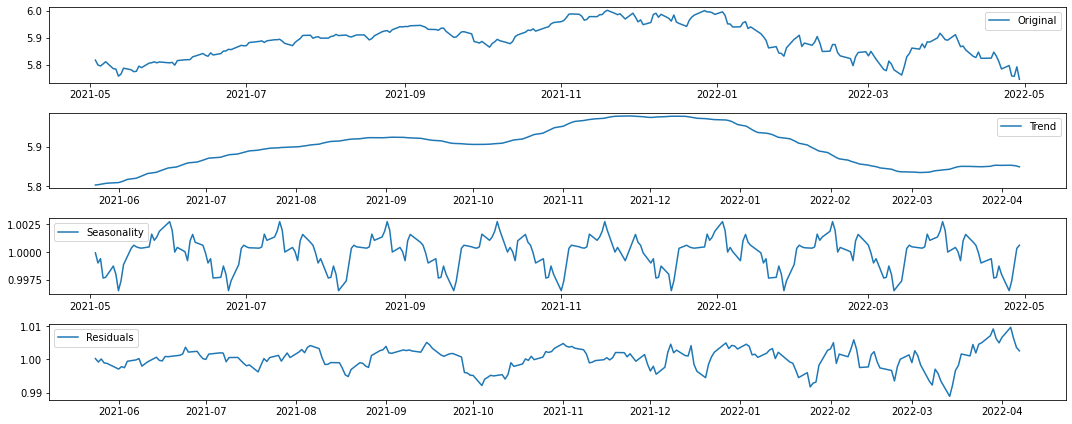

In [10]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

▶︎ 트렌드를 보니 한동안 상승하다가, 올해 초부터 하강세로 접어들었습니다. 계절성은 뚜렷한 패턴이 보이네요.

원래라면 계절성이나 트렌드 데이터 보정을 해줘야 하지만, decompose 메소드를 쓰고 있으니 Residual만 확인해 봅시다.

### (7-4) Residual 안정성 확인

In [11]:
# Residual

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.298481
p-value                          0.000006
#Lags Used                      14.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


 ▶︎ p값이 아주 낮고 안정적으로 나옵니다. 이 데이터는 신뢰할 만 하다는 뜻이겠지요?

## (8) 학습/테스트 데이터셋 분리

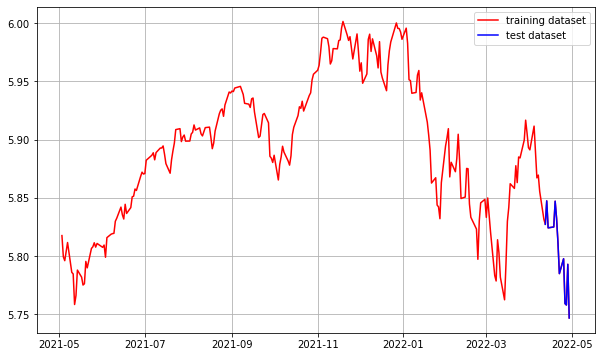

In [12]:
# 학습 비율 95%

train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # ts_log로 자연스러운 그래프 사용
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


▶︎ 사실 러시아-우크라이나 전쟁 때문에 최근 데이터를 예측하기는 조금 어려울 겁니다.

모델이 학습한 데이터의 기간 중에는 그만한 전쟁이 없었으니까요.

그래서 학습비율을 조금 높여서 전쟁이 주가에 미친 영향까지 포함시켜 보겠습니다.

예상으로는 데이터 숫자가 더 많을 때 효과적일 것 같습니다. 하지만 지금은 daily 데이터를 불러왔으니 이걸로 진행합니다.

나중에 다른 종목을 분석할 때는 minute이나 hour 단위로 분석하면 더 정밀하게 분석할 수 있을 겁니다.

> **참고: [학습 데이터 비율을 어떻게 잡아야 할까?]** |  https://brunch.co.kr/@coolmindory/31

## (9) 적정 ARIMA 수 구하기

### (9-1) ACF, PACF 그리기 (p, q 구하기)

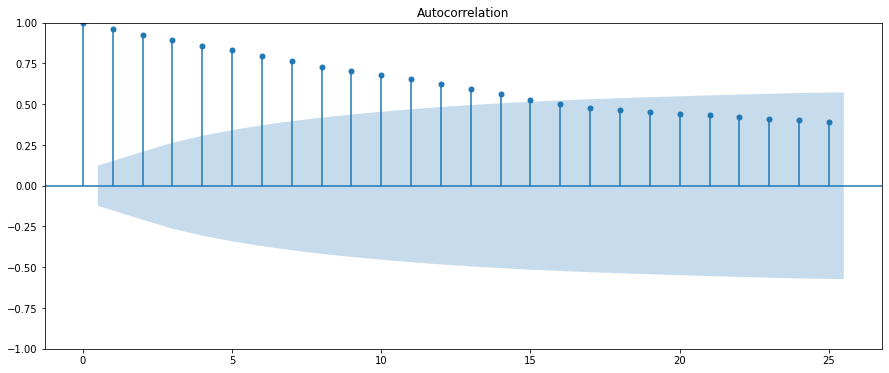

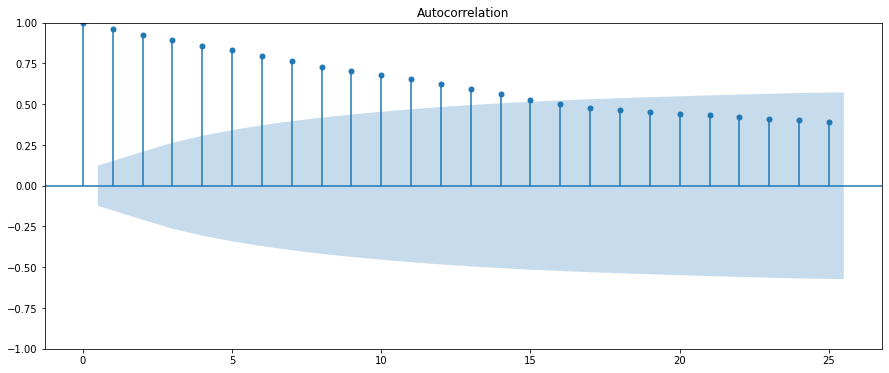

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 그래프 (q값)
plot_acf(ts_log)


▶︎ x축은 상관계수, y축은 시차 수입니다.

ACF는 자기상관계수, 그러니까 자기 자신과 얼마나 밀접한 관계를 갖고 있는가에 대한 함수입니다.

"과거의 자신이 했던 행동을 현재에도 반복한다면, 자기 자신과 상관관계가 있다고 할 수 있다" 는 말이지요. 즉, ACF를 통해서 AR 모델을 설명할 수 있습니다.

쉽게 말해서 위 그래프의 색칠된 부분 안에 들어가는 시점부터 두 요소의 상관 관계를 제대로 분석할 수 있다는 뜻입니다.

해당 지점은 16번째이니 최소 15개까지는 학습을 해야 하겠군요.

#### <span style="color:indianred"> 따라서 q값은 15입니다! </span>



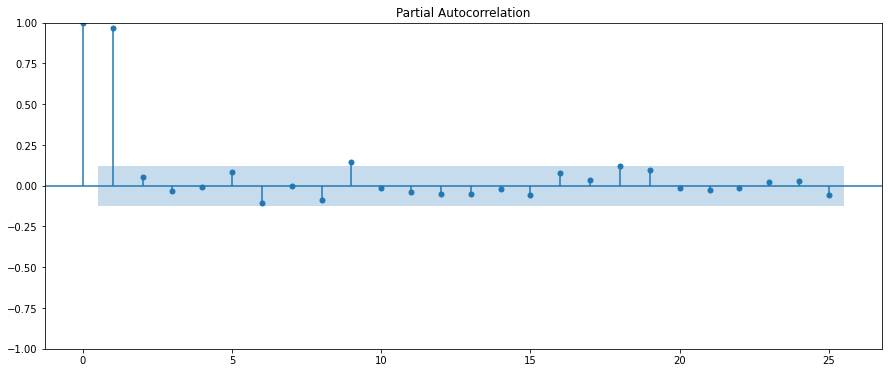

In [14]:
# PACF (p)
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()         


▶︎ PACF는 부분 자기상관함수입니다.

이게 무슨 말이냐? ACF는 과거와 현재 기간 사이의 변수들을 토대로 현재 시점을 예측한다고 했죠?

PACF는 과거의 변수들을 고려하지 않고, 과거 딱 고 시점과 현재 시점만의 상관관계만을 다루는 함수입니다.

ACF랑 원리는 같습니다.


#### <span style="color:indianred"> 따라서 p값은 1입니다! </span>


### (9-2) 차분 안정성 확인 (d 구하기)


Results of Dickey-Fuller Test:
Test Statistic                -1.545154e+01
p-value                        2.780048e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


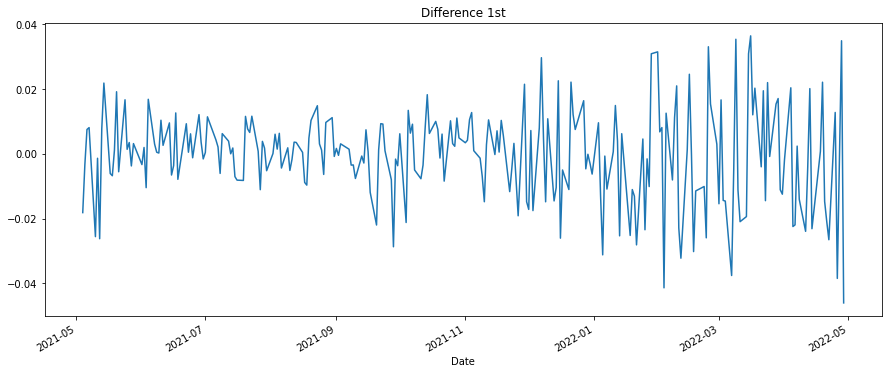

In [15]:
# 1차 차분

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

▶︎ 음... 완벽하진 않지만 꽤 stationary해 진 것 같습니다. p값도 상당히 낮아요.

하지만 뭔가 아쉽습니다. 아직 변동성이 다 사라지지 않은 것 같네요.

차분을 한 번 더 해보겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -8.389871e+00
p-value                        2.382643e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


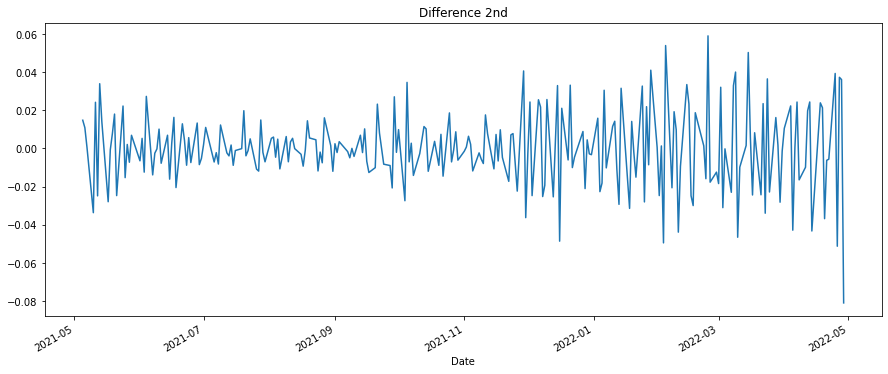

In [16]:
# 2차 차분

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

▶︎ WA! 상당히 안정적으로 변했네요!

혹시 3차 차분을 하면 더 안정적으로 될까요?

Results of Dickey-Fuller Test:
Test Statistic                -9.607598e+00
p-value                        1.848211e-16
#Lags Used                     1.500000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


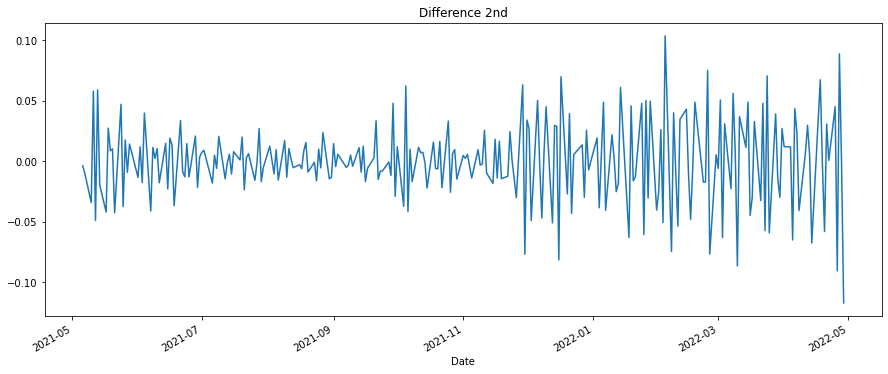

In [17]:
# 3차 차분

diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_3)

▶︎ 살짝 애매하군요.

#### <span style="color:indianred"> d=2부터 꽤 안정적으로 보이니, 일단 d=2로 놓고 진행해 보겠습니다. </span>

## (10) ARIMA 모델 훈련 & 테스트

### (10-1) 모델 빌드 & fitting

In [18]:
# Build Model

model = ARIMA(train_data, order=(1, 2, 15))  # p=1, d=2, q=15
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  239
Model:                ARIMA(1, 2, 15)   Log Likelihood                 691.017
Date:                Wed, 04 May 2022   AIC                          -1348.034
Time:                        09:16:01   BIC                          -1289.077
Sample:                             0   HQIC                         -1324.270
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6836      0.117     -5.854      0.000      -0.913      -0.455
ma.L1         -0.1517      0.132     -1.146      0.252      -0.411       0.108
ma.L2         -0.7792      0.102     -7.662      0.0

▶︎ 어...Warning이 뜨는데... 아, 경고가 아니라 참고하라고 알려주는 거군요. 다행입니다.

결과를 시각화해봅시다.

### (9-2) 결과 시각화

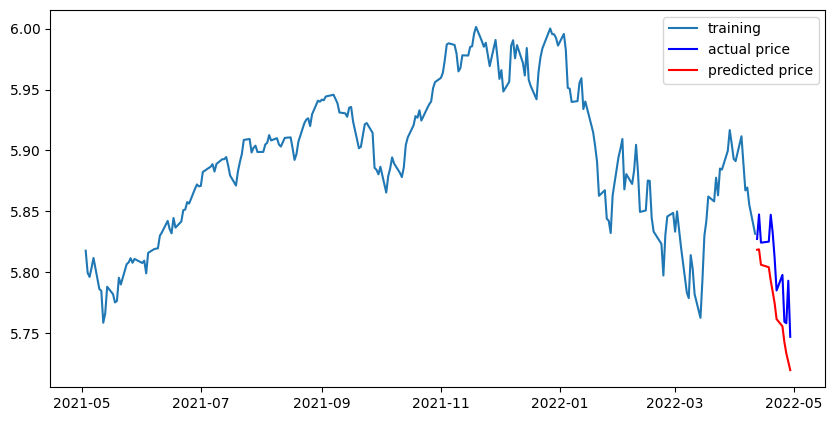

In [19]:
# Forecast
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% 신뢰수준
fc = np.array(fc)


# pandas series로 변환
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot으로 시각화
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

▶︎ 오, 상당히 정확한 것처럼 보입니다!

실제 데이터가 조금 더 위쪽으로 자꾸 치솟는 경향은 아무래도 주가 폭락을 막기 위한 사람들의 노력의 흔적이겠죠?

### (9-3) 정확도 판정

In [20]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  136.8831001430811
MAE:  10.474089982833116
RMSE:  11.69970513060398
MAPE: 3.15%


▶︎ MAPE 값도 적절하네요. Profit!

---

# 02. SPY ETF 분석
>- SPY는 S&P 500을 추종하는 ETF입니다.
>- S&P 500은 미국의 신용평가사인 standard & poors가 나스닥, 뉴욕증시에서 선별한 500개 기업의 주가 지수입니다.
>- 구체적으로는 공업주 400개, 운수주 20개, 공공주 40개, 금융주 20개로 구성돼 있습니다.
>- 시가 총액에 따라서 종목을 선정하기 때문에 대표성이 크다고 평가받고 있습니다. 미 증시 투자할 때 가장 많이 참고하는 지수이기도 하죠.

▶︎ 편의상 분석 과정은 모듈화해서 사용할게요!

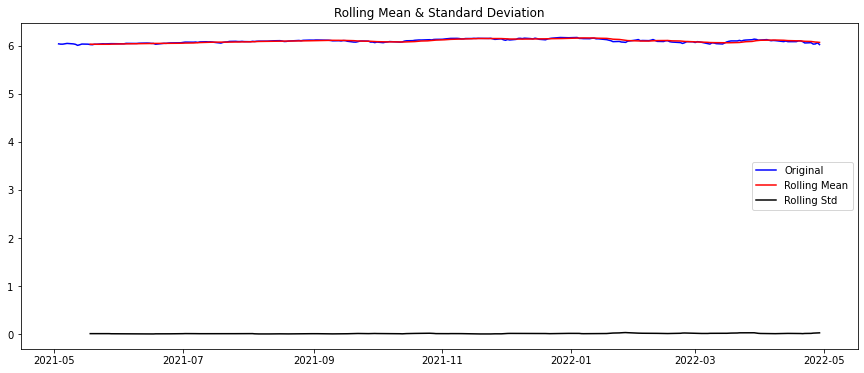

Results of Dickey-Fuller Test:
Test Statistic                  -2.014766
p-value                          0.280137
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.274312
p-value                          0.000006
#Lags Used                       1.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


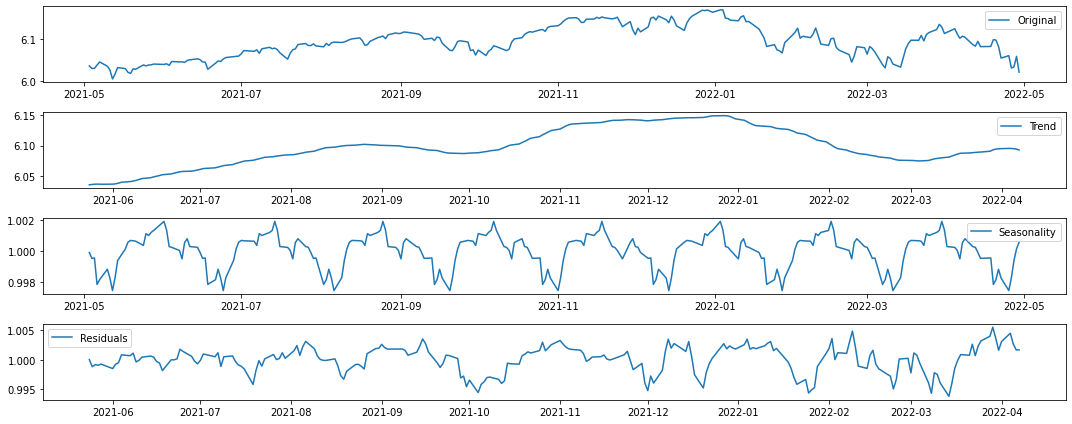

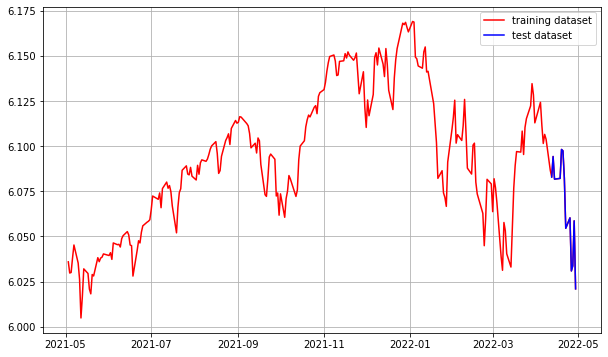

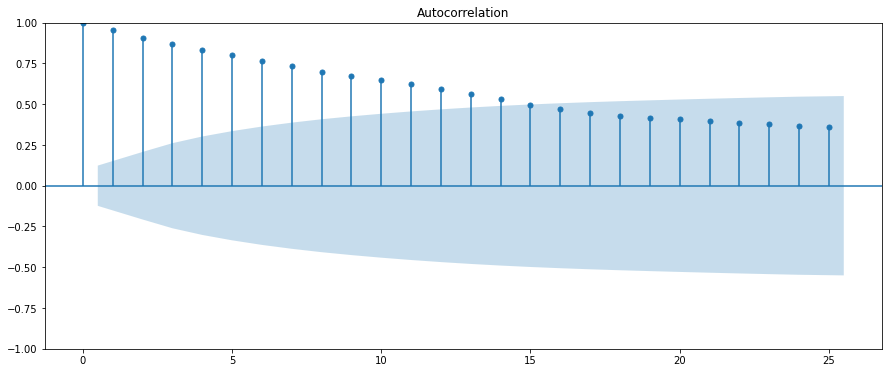

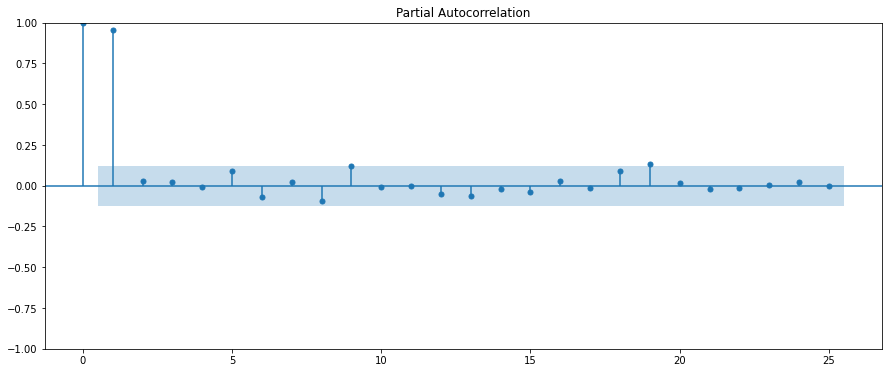

Results of Dickey-Fuller Test:
Test Statistic                -1.227214e+01
p-value                        8.592709e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.137358e+00
p-value                        1.050447e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


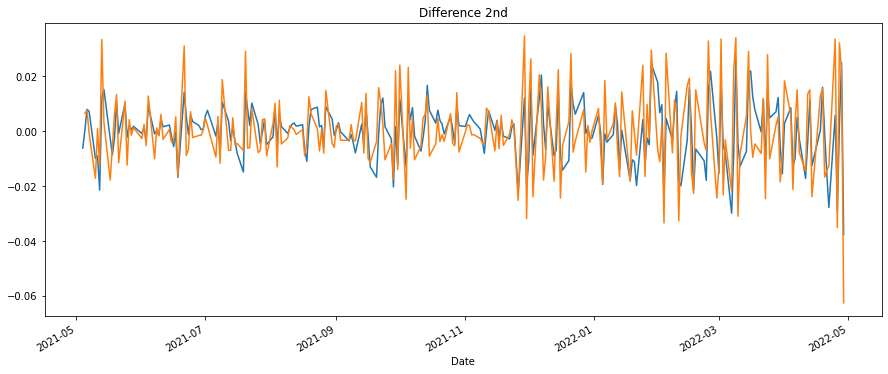

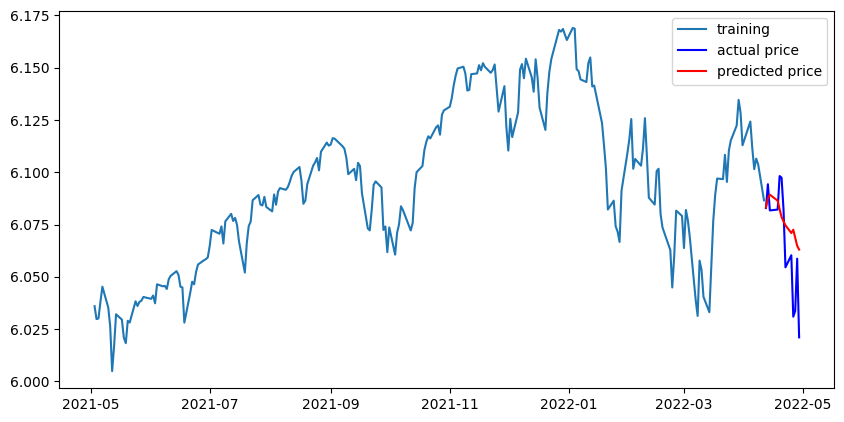

MSE:  84.25628382088505
MAE:  7.0926170923445095
RMSE:  9.179122170495665
MAPE: 1.67%


In [21]:
# 모듈 가져오기
import arima_pred

# pred(p, d, q, train_rate, file_path) 형식으로 사용합니다.
# arima_pred.arm_pred(2, 1, 2, 0.95, '/aiffel/exploration/E_03/SPY.csv') # 초기값 임의 배정 후 조정

arima_pred.arm_pred(1, 2, 15, 0.95, '/aiffel/exploration/E_03/SPY.csv') # p=1, d=2, q=15 / d=3일때는 오차가 너무 커짐



▶︎ MAPE 값이 1.67%로 QQQ를 분석했을 때보다 훨씬 낮아졌습니다. 좋아요!

그래프를 보니 예측 적중률도 꽤 높습니다. 흠, 그런데 실제 주가의 이동을 보니 QQQ보다 더 잘 못 버티고 예측치보다 더 내려가 버렸군요.

아까 QQQ는 나스닥을 추종하고, SPY는 S&P를 추종한다고 했었죠?

QQQ는 비교적 잘 버티는 반면, SPY는 완전히 나락으로 가고 있어요. 😢

---

# ESGU ETF 분석
- 이번에는 다른 테마의 ETF를 살펴보겠습니다.
- ESGU는 ESG(Environmental, Social and Governance)를 테마로 하는 ETF입니다.
- ESG하면 흔히 생각하는 환경 기업도 투자하지만, 포트폴리오는 주로 IT 기술 기업들로 구성돼 있습니다.
- ESG 지수를 기반으로 투자하기 때문에, 무기와 관련된 사업(방위산업체 등), 담배, 석탄이나 석유 등의 에너지 회사는 투자하지 않는 경향이 있습니다.

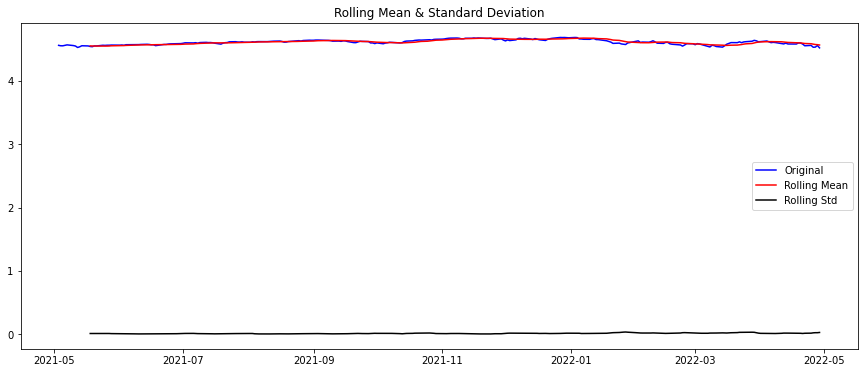

Results of Dickey-Fuller Test:
Test Statistic                  -1.728683
p-value                          0.416398
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.036955
p-value                          0.000019
#Lags Used                      14.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


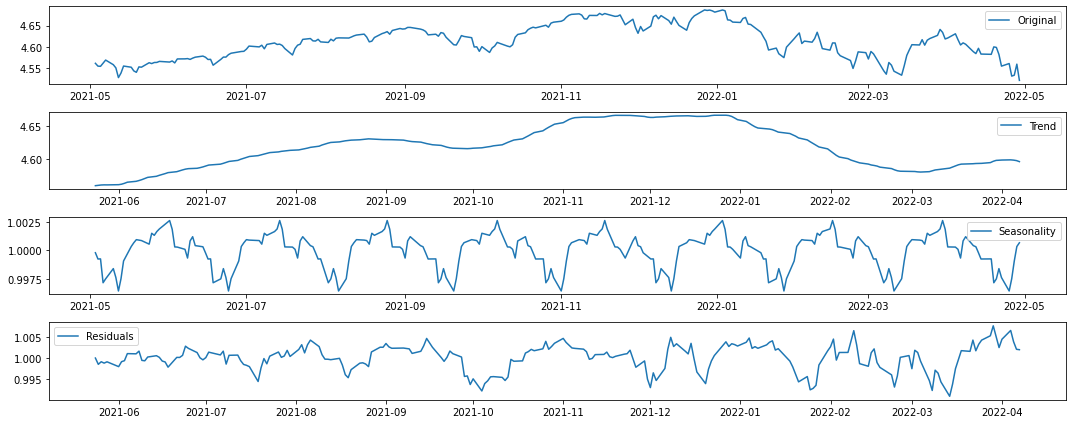

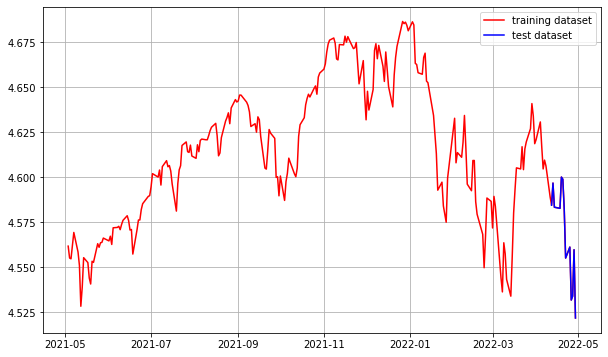

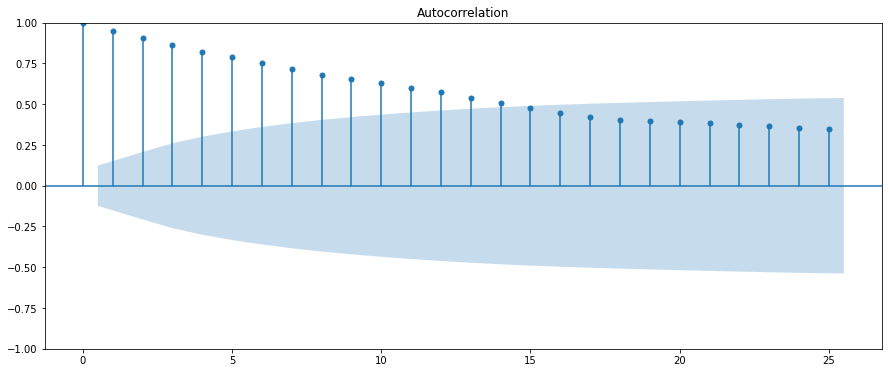

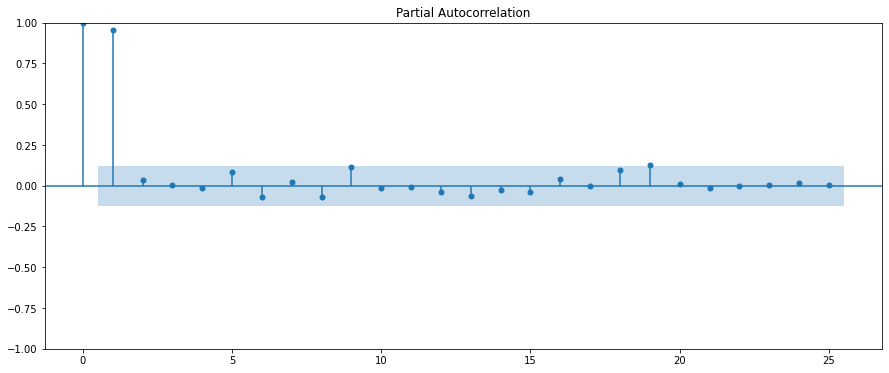

Results of Dickey-Fuller Test:
Test Statistic                -1.218186e+01
p-value                        1.345838e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.256911e+00
p-value                        5.207402e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


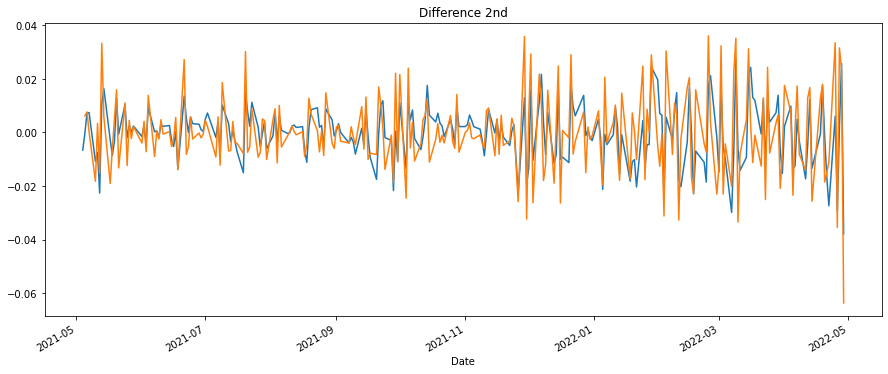

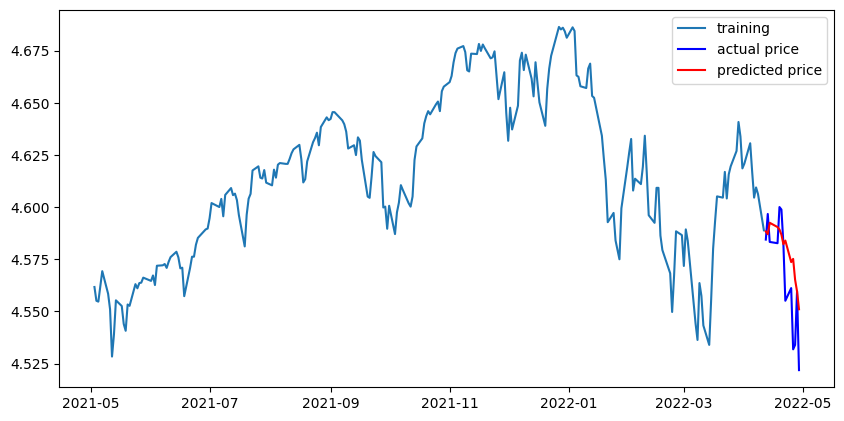

MSE:  3.6389491393003954
MAE:  1.467051657513599
RMSE:  1.907602982619915
MAPE: 1.55%


In [22]:
# 돌려돌려~

# arima_pred.arm_pred(1, 1, 15, 0.95, '/aiffel/exploration/E_03/ESGU.csv') # 임의지정 후 조정

arima_pred.arm_pred(1, 3, 14, 0.95, '/aiffel/exploration/E_03/ESGU.csv') # p=1, d=3, q=14


▶︎ 음, 이번에도 SPY와 마찬가지로 조금 버티다가 훅 내려가 버리는 모습을 볼 수 있습니다.

심지어 MAPE 값은 점점 낮아지고 있군요. 그래도 앞서 살펴봤던 SPY ETF에 비해서는 잘 버티는 편입니다.


---

# 결론

>#### QQQ
>- 나스닥100 추종 | 기술기업 위주 | 예측치보다 높음
>
>#### SPY
>- S&P500 추종  | 제조,공업 위주 | 예측치보다 많이 낮음
>
>#### ESGU
>- ESG, IT 우량주 위주 | 예측치보다는 낮지만 SPY보단 안정적

### ▶︎ 즉, 우리는 현재 하락세에 <span style="color:indianred">기술기업주(주로 IT)가 잘 버티고, 제조업/공업 회사들이 타격을 크게 받고 있다</span>는  인사이트를 얻을 수 있습니다!

(엄밀히는 ETF 개별 포트폴리오 구성에 따라 가중치를 따로 줘야 하지만, 일단 이런 식으로 인사이트를 얻을 수 있다- 고만 이해하고 넘어가겠습니다.)


>사실 직관적으로 생각하면 당연히 IT 기업이 제조업/공업 회사보다 리스크 헷징은 더 쉽다고 생각할 수도 있습니다.
>
>어쨌든 후자는 실 제품을 제조해야 하니까 생산비가 많이 들어가죠. 이게 디지털 기업의 장점이기도 하고요.
>
>하지만 이번 프로젝트에서는 **<U>데이터를 가지고 실제로 인사이트를 도출해냈다</U>**는 데 의의를 둘게요! 😉

---

# <span style="color:slateblue">회고</span> 

역시 세상에 완벽한 건 없는 것 같습니다. 😢

일부러 크고 작은 외부 변수의 영향력을 줄이고자 지수추종형 펀드들을 분석해봤는데, 그럼에도 불구하고 외부 변수의 영향력이 생각보다 강한 것 같더라고요. 아마 인공지능을 주식 분석에 활용하려는 사람이 굉장히 많을 것 같은데, 이번에 한 ARIMA 말고도 더 성능이 좋은 모델이 있지 않을까요?

결론 부분에서 적은 것처럼 개별 ETF의 포트폴리오 구성에 따른 가중치라던가, ETF의 평균 수익률(소속 트레이더들의 실력)이라던가... 당장 생각나는 추가 변수들이 있는데 실력이 부족해서 구현을 어떻게 해야 할 지는 잘 모르겠습니다. ㅠㅠ

그리고 p,d,q 값을 구할 때, 자료를 찾아보니 보통 시계열 데이터들이 AR이나 MA 둘 중 하나의 특성을 갖기 때문에 p\*q=0, p+q < 2인 값을 범용적으로 쓴다고 하던데... 당장 주가만 해도 굉장히 범용적으로 쓰이는 데이터 같은데 저 조건을 만족하는 값보다 p,q,d를 직접 조정해서 쓰는 편이 정확도가 더 높던데, 이유가 뭔지 궁금합니다. 검색해도 분석에 대한 방법론만 나오고 해당 내용에 대한 이유는 찾기가 힘들어서요. 제 생각엔 주가 자체가 워낙 변동성이 심해서 여러 가지 지표를 조합해서 사용하는 게 더 성능이 좋은게 아닐까... 싶긴 한데, 그럼 또 대부분의 시계열 데이터들이 같은 특성을 갖지 않나 싶어서 자꾸 사람 헷갈리게 하네요....

그리고 예측 정확도도 아마 데이터를 더 큰 범위에 좁은 단위로 잡아서 분석해보면 정밀하게 분석이 가능할 것 같은데... 생각보다 오래 거래된 주식이 없어서 빅데이터라고 할 만한 데이터 크기를 확보하기가 어렵네요. 현업에선 접근성이 또 다르겠죠?

# Ref.
>- [학습 데이터, 얼마가 적정할까] | https://brunch.co.kr/@coolmindory/31
>- [시계열 분해 개념] | https://bit.ly/3OW26yz
>- [ACF, PACF 개념] | https://blog.naver.com/dldbstn30/222617747168, https://blog.naver.com/tjgml1343/222077619748